# Partie 1: Data Preparation and Exploration

### Exercice 1: Loading the Turtle File

In [1]:
from rdflib import Graph, URIRef
from collections import defaultdict

# Charger le fichier Turtle
human_file = "data/human.ttl"
graph = Graph()
graph.parse(human_file, format="turtle")

# Question 1: How many unique entities and relations are in human.ttl?
entities = set()
relations = set()

for sujet, predicat, objet in graph:
    entities.add(sujet)
    entities.add(objet)
    relations.add(predicat)

print(f"Nombre d'entités uniques : {len(entities)}")
print(f"Nombre de relations uniques : {len(relations)}")

# Question 2: What is the size of the graph in terms of the number of triples?
num_triples = len(graph)
print(f"Nombre de triples dans le graphe : {num_triples}")

# Question 3: Identify some entities and relationships that could illustrate interesting link cases
entity_relations = defaultdict(set)
for sujet, predicat, objet in graph:
    if isinstance(sujet, URIRef) and isinstance(objet, URIRef):
        entity_relations[sujet].add(predicat)

print("\nExemples d'entités et leurs relations :")
for entity, rels in list(entity_relations.items())[:5]:  # Affiche les 5 premières entités pour l'exemple
    print(f"Entité: {entity}")
    for rel in rels:
        print(f"  Relation: {rel}")



Nombre d'entités uniques : 65
Nombre de relations uniques : 15
Nombre de triples dans le graphe : 95

Exemples d'entités et leurs relations :
Entité: http://www.inria.fr/human/data#Eve
  Relation: http://www.inria.fr/human#hasFriend
  Relation: http://www.w3.org/1999/02/22-rdf-syntax-ns#type
  Relation: http://www.inria.fr/human#hasSpouse
Entité: http://www.inria.fr/human/data#Karl
  Relation: http://www.inria.fr/human#hasFriend
  Relation: http://www.w3.org/1999/02/22-rdf-syntax-ns#type
  Relation: http://www.inria.fr/human#hasSpouse
Entité: http://www.inria.fr/human/data#Jennifer
  Relation: http://www.w3.org/1999/02/22-rdf-syntax-ns#type
  Relation: http://www.inria.fr/human#hasSpouse
Entité: http://www.inria.fr/human/data#Flora
  Relation: http://www.w3.org/1999/02/22-rdf-syntax-ns#type
  Relation: http://www.inria.fr/human#hasSpouse
  Relation: http://www.inria.fr/human#hasChild
Entité: http://www.inria.fr/human/data#Alice
  Relation: http://www.inria.fr/human#hasFriend
  Relation

### Exercice 2: Preparing Data for Learning

In [2]:
from rdflib import Graph
import pandas as pd
import random
from sklearn.model_selection import train_test_split
import numpy as np


triples = list(graph)

# Split triples into training and test sets
train_triples, test_triples = train_test_split(
    triples, test_size=0.2, random_state=42
)

# Generate negative samples
def generate_negative_samples(positive_triples, num_neg_samples=1):
    # Extract unique entities from the graph
    entities = set()
    for sujet, predicat, objet in graph:
        if isinstance(sujet, URIRef) and isinstance(objet, URIRef):
            entities.add(sujet)
            entities.add(objet)
    
    negative_samples = []
    entities_list = list(entities)
    
    for s, p, o in positive_triples:
        for _ in range(num_neg_samples):
            # Randomly decide to corrupt subject or object
            corrupt_subject = np.random.random() < 0.5
            
            if corrupt_subject:
                # Replace subject with a random entity
                neg_s = np.random.choice(entities_list)
                neg_sample = (neg_s, p, o)
            else:
                # Replace object with a random entity
                neg_o = np.random.choice(entities_list)
                neg_sample = (s, p, neg_o)
            
            # Ensure negative sample is not in original graph
            while neg_sample in graph:
                if corrupt_subject:
                    neg_s = np.random.choice(entities_list)
                    neg_sample = (neg_s, p, o)
                else:
                    neg_o = np.random.choice(entities_list)
                    neg_sample = (s, p, neg_o)
            
            negative_samples.append(neg_sample)
    
    return negative_samples

# Generate negative samples for training set
train_negative_samples = generate_negative_samples(train_triples)

# Print some information about the data preparation
print("\nData Preparation Summary:")
print(f"Total triples: {len(triples)}")
print(f"Training triples: {len(train_triples)}")
print(f"Test triples: {len(test_triples)}")
print(f"Negative samples generated: {len(train_negative_samples)}")


Data Preparation Summary:
Total triples: 95
Training triples: 76
Test triples: 19
Negative samples generated: 76


# Partie 2: Implementation of Embedding Models

In [3]:
from rdflib import Graph
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from pykeen.pipeline import pipeline
from pykeen.models import TransE, DistMult, ComplEx, RotatE
from pykeen.triples import TriplesFactory

# Load the Turtle files
graph = Graph()
graph.parse("data/human.ttl", format="turtle")
graph.parse("data/humanrdfs.ttl", format="turtle")

# Extract triples
triples = [(str(s), str(p), str(o)) for s, p, o in graph]

# Convert triples to a NumPy array
triples_array = np.array(triples, dtype=object)

# Split triples into training and test sets
train_triples, test_triples = train_test_split(
    triples_array, test_size=0.2, random_state=42
)

# Create TriplesFactory for training and testing
training = TriplesFactory.from_labeled_triples(train_triples)
testing = TriplesFactory.from_labeled_triples(test_triples, entity_to_id=training.entity_to_id, relation_to_id=training.relation_to_id)

# Function to train and evaluate a model
def train_and_evaluate_model(model_class, training, testing, embedding_dim=200):
    result = pipeline(
        model=model_class,
        training=training,
        testing=testing,
        model_kwargs=dict(embedding_dim=embedding_dim),
        training_kwargs=dict(num_epochs=500),
        evaluation_kwargs=dict(use_tqdm=False),
    )
    print(f"\nResults for {model_class.__name__} with embedding_dim={embedding_dim}:")
    metric_results_df = result.metric_results.to_df()
    print(metric_results_df)
    return metric_results_df

# Train and evaluate TransE
transE_results = train_and_evaluate_model(TransE, training, testing)

# Train and evaluate DistMult
distMult_results = train_and_evaluate_model(DistMult, training, testing)

# Train and evaluate ComplEx
complEx_results = train_and_evaluate_model(ComplEx, training, testing)

# Train and evaluate RotatE
rotatE_results = train_and_evaluate_model(RotatE, training, testing)

# Inspect available metrics for TransE
available_metrics = transE_results['Metric'].unique()
print("\nAvailable metrics for TransE:", available_metrics)

for embedding_dim in [100, 200, 300]:
    result = pipeline(
        model=TransE,
        training=training,
        testing=testing,
        model_kwargs=dict(embedding_dim=embedding_dim),
        training_kwargs=dict(num_epochs=50),
        evaluation_kwargs=dict(use_tqdm=False),
    )
    result_df = result.metric_results.to_df()
    print(f"\nResults for TransE with embedding_dim={embedding_dim}:")
    print(result_df)

    result_df = pipeline(
        model=RotatE,
        training=training,
        testing=testing,
        model_kwargs=dict(embedding_dim=embedding_dim),
        training_kwargs=dict(num_epochs=50),
        evaluation_kwargs=dict(use_tqdm=False),
    ).metric_results.to_df()
    print(f"\nResults for RotatE with embedding_dim={embedding_dim}:")
    print(result_df)
    
    result_df = pipeline(
        model=DistMult,
        training=training,
        testing=testing,
        model_kwargs=dict(embedding_dim=embedding_dim),
        training_kwargs=dict(num_epochs=50),
        evaluation_kwargs=dict(use_tqdm=False),
    ).metric_results.to_df()
    print(f"\nResults for DistMult with embedding_dim={embedding_dim}:")
    print(result_df)

    result_df = pipeline(
        model=ComplEx,
        training=training,
        testing=testing,
        model_kwargs=dict(embedding_dim=embedding_dim),
        training_kwargs=dict(num_epochs=50),
        evaluation_kwargs=dict(use_tqdm=False),
    ).metric_results.to_df()
    print(f"\nResults for ComplEx with embedding_dim={embedding_dim}:")
    print(result_df)


c:\Users\Flyomega\Desktop\EPITA\ING3\Graphe de connaissances\TP2_Graphe\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
You're trying to map triples with 26 entities and 1 relations that are not in the training set. These triples will be excluded from the mapping.
In total 27 from 49 triples were filtered out
No random seed is specified. Setting to 1655146042.
No cuda devices were available. The model runs on CPU
Training epochs on cpu: 100%|██████████| 500/500 [00:57<00:00,  8.69epoch/s, loss=0, prev_loss=0]             
INFO:pykeen.evaluation.evaluator:Evaluation took 0.05s seconds
INFO:pykeen.pipeline.api:Using device: None



Results for TransE with embedding_dim=200:
     Side    Rank_type              Metric      Value
0    head   optimistic               count  22.000000
1    tail   optimistic               count  22.000000
2    both   optimistic               count  44.000000
3    head    realistic               count  22.000000
4    tail    realistic               count  22.000000
..    ...          ...                 ...        ...
220  tail    realistic  adjusted_hits_at_k   0.562255
221  both    realistic  adjusted_hits_at_k   0.294121
222  head  pessimistic  adjusted_hits_at_k   0.025513
223  tail  pessimistic  adjusted_hits_at_k   0.562255
224  both  pessimistic  adjusted_hits_at_k   0.294121

[225 rows x 4 columns]


Training epochs on cpu: 100%|██████████| 500/500 [00:51<00:00,  9.76epoch/s, loss=0.634, prev_loss=0.64] 
INFO:pykeen.evaluation.evaluator:Evaluation took 0.04s seconds
INFO:pykeen.pipeline.api:Using device: None



Results for DistMult with embedding_dim=200:
     Side    Rank_type              Metric      Value
0    head   optimistic               count  22.000000
1    tail   optimistic               count  22.000000
2    both   optimistic               count  44.000000
3    head    realistic               count  22.000000
4    tail    realistic               count  22.000000
..    ...          ...                 ...        ...
220  tail    realistic  adjusted_hits_at_k   0.854085
221  both    realistic  adjusted_hits_at_k   0.805275
222  head  pessimistic  adjusted_hits_at_k   0.756378
223  tail  pessimistic  adjusted_hits_at_k   0.854085
224  both  pessimistic  adjusted_hits_at_k   0.805275

[225 rows x 4 columns]


Training epochs on cpu: 100%|██████████| 500/500 [00:49<00:00, 10.02epoch/s, loss=0.371, prev_loss=0.219]
INFO:pykeen.evaluation.evaluator:Evaluation took 0.07s seconds
INFO:pykeen.pipeline.api:Using device: None



Results for ComplEx with embedding_dim=200:
     Side    Rank_type              Metric      Value
0    head   optimistic               count  22.000000
1    tail   optimistic               count  22.000000
2    both   optimistic               count  44.000000
3    head    realistic               count  22.000000
4    tail    realistic               count  22.000000
..    ...          ...                 ...        ...
220  tail    realistic  adjusted_hits_at_k   0.075873
221  both    realistic  adjusted_hits_at_k   0.050715
222  head  pessimistic  adjusted_hits_at_k   0.025513
223  tail  pessimistic  adjusted_hits_at_k   0.075873
224  both  pessimistic  adjusted_hits_at_k   0.050715

[225 rows x 4 columns]


Training epochs on cpu: 100%|██████████| 500/500 [00:43<00:00, 11.55epoch/s, loss=0.0215, prev_loss=0.0108]   
INFO:pykeen.evaluation.evaluator:Evaluation took 0.02s seconds
INFO:pykeen.pipeline.api:Using device: None



Results for RotatE with embedding_dim=200:
     Side    Rank_type              Metric      Value
0    head   optimistic               count  22.000000
1    tail   optimistic               count  22.000000
2    both   optimistic               count  44.000000
3    head    realistic               count  22.000000
4    tail    realistic               count  22.000000
..    ...          ...                 ...        ...
220  tail    realistic  adjusted_hits_at_k   0.464979
221  both    realistic  adjusted_hits_at_k   0.391484
222  head  pessimistic  adjusted_hits_at_k   0.317859
223  tail  pessimistic  adjusted_hits_at_k   0.464979
224  both  pessimistic  adjusted_hits_at_k   0.391484

[225 rows x 4 columns]

Available metrics for TransE: ['count' 'inverse_harmonic_mean_rank' 'inverse_arithmetic_mean_rank'
 'geometric_mean_rank' 'median_absolute_deviation' 'harmonic_mean_rank'
 'z_inverse_harmonic_mean_rank' 'standard_deviation' 'variance'
 'adjusted_geometric_mean_rank_index' 'adjusted_

Training epochs on cpu: 100%|██████████| 50/50 [00:04<00:00, 11.51epoch/s, loss=0.152, prev_loss=0.161]
INFO:pykeen.evaluation.evaluator:Evaluation took 0.02s seconds
INFO:pykeen.pipeline.api:Using device: None



Results for TransE with embedding_dim=100:
     Side    Rank_type              Metric      Value
0    head   optimistic               count  22.000000
1    tail   optimistic               count  22.000000
2    both   optimistic               count  44.000000
3    head    realistic               count  22.000000
4    tail    realistic               count  22.000000
..    ...          ...                 ...        ...
220  tail    realistic  adjusted_hits_at_k   0.221787
221  both    realistic  adjusted_hits_at_k   0.172418
222  head  pessimistic  adjusted_hits_at_k   0.122961
223  tail  pessimistic  adjusted_hits_at_k   0.221787
224  both  pessimistic  adjusted_hits_at_k   0.172418

[225 rows x 4 columns]


Training epochs on cpu: 100%|██████████| 50/50 [00:04<00:00, 11.00epoch/s, loss=0.613, prev_loss=0.614]
INFO:pykeen.evaluation.evaluator:Evaluation took 0.05s seconds
INFO:pykeen.pipeline.api:Using device: None



Results for RotatE with embedding_dim=100:
     Side    Rank_type              Metric      Value
0    head   optimistic               count  22.000000
1    tail   optimistic               count  22.000000
2    both   optimistic               count  44.000000
3    head    realistic               count  22.000000
4    tail    realistic               count  22.000000
..    ...          ...                 ...        ...
220  tail    realistic  adjusted_hits_at_k   0.464979
221  both    realistic  adjusted_hits_at_k   0.269781
222  head  pessimistic  adjusted_hits_at_k   0.074237
223  tail  pessimistic  adjusted_hits_at_k   0.464979
224  both  pessimistic  adjusted_hits_at_k   0.269781

[225 rows x 4 columns]


Training epochs on cpu: 100%|██████████| 50/50 [00:04<00:00, 10.23epoch/s, loss=0.989, prev_loss=0.989]
INFO:pykeen.evaluation.evaluator:Evaluation took 0.05s seconds
INFO:pykeen.pipeline.api:Using device: None



Results for DistMult with embedding_dim=100:
     Side    Rank_type              Metric      Value
0    head   optimistic               count  22.000000
1    tail   optimistic               count  22.000000
2    both   optimistic               count  44.000000
3    head    realistic               count  22.000000
4    tail    realistic               count  22.000000
..    ...          ...                 ...        ...
220  tail    realistic  adjusted_hits_at_k  -0.021404
221  both    realistic  adjusted_hits_at_k  -0.022307
222  head  pessimistic  adjusted_hits_at_k  -0.023212
223  tail  pessimistic  adjusted_hits_at_k  -0.021404
224  both  pessimistic  adjusted_hits_at_k  -0.022307

[225 rows x 4 columns]


Training epochs on cpu: 100%|██████████| 50/50 [00:05<00:00,  9.53epoch/s, loss=9, prev_loss=8.99]   
INFO:pykeen.evaluation.evaluator:Evaluation took 0.04s seconds
INFO:pykeen.pipeline.api:Using device: None



Results for ComplEx with embedding_dim=100:
     Side    Rank_type              Metric      Value
0    head   optimistic               count  22.000000
1    tail   optimistic               count  22.000000
2    both   optimistic               count  44.000000
3    head    realistic               count  22.000000
4    tail    realistic               count  22.000000
..    ...          ...                 ...        ...
220  tail    realistic  adjusted_hits_at_k  -0.070042
221  both    realistic  adjusted_hits_at_k  -0.070988
222  head  pessimistic  adjusted_hits_at_k  -0.071936
223  tail  pessimistic  adjusted_hits_at_k  -0.070042
224  both  pessimistic  adjusted_hits_at_k  -0.070988

[225 rows x 4 columns]


Training epochs on cpu: 100%|██████████| 50/50 [00:05<00:00,  9.88epoch/s, loss=0.0339, prev_loss=0.0954]
INFO:pykeen.evaluation.evaluator:Evaluation took 0.05s seconds
INFO:pykeen.pipeline.api:Using device: None



Results for TransE with embedding_dim=200:
     Side    Rank_type              Metric      Value
0    head   optimistic               count  22.000000
1    tail   optimistic               count  22.000000
2    both   optimistic               count  44.000000
3    head    realistic               count  22.000000
4    tail    realistic               count  22.000000
..    ...          ...                 ...        ...
220  tail    realistic  adjusted_hits_at_k   0.173149
221  both    realistic  adjusted_hits_at_k   0.099396
222  head  pessimistic  adjusted_hits_at_k   0.025513
223  tail  pessimistic  adjusted_hits_at_k   0.173149
224  both  pessimistic  adjusted_hits_at_k   0.099396

[225 rows x 4 columns]


Training epochs on cpu: 100%|██████████| 50/50 [00:05<00:00,  9.96epoch/s, loss=0.476, prev_loss=0.473]
INFO:pykeen.evaluation.evaluator:Evaluation took 0.05s seconds
INFO:pykeen.pipeline.api:Using device: None



Results for RotatE with embedding_dim=200:
     Side    Rank_type              Metric      Value
0    head   optimistic               count  22.000000
1    tail   optimistic               count  22.000000
2    both   optimistic               count  44.000000
3    head    realistic               count  22.000000
4    tail    realistic               count  22.000000
..    ...          ...                 ...        ...
220  tail    realistic  adjusted_hits_at_k   0.367702
221  both    realistic  adjusted_hits_at_k   0.148077
222  head  pessimistic  adjusted_hits_at_k  -0.071936
223  tail  pessimistic  adjusted_hits_at_k   0.367702
224  both  pessimistic  adjusted_hits_at_k   0.148077

[225 rows x 4 columns]


Training epochs on cpu: 100%|██████████| 50/50 [00:05<00:00,  9.47epoch/s, loss=0.983, prev_loss=0.984]
INFO:pykeen.evaluation.evaluator:Evaluation took 0.05s seconds
INFO:pykeen.pipeline.api:Using device: None



Results for DistMult with embedding_dim=200:
     Side    Rank_type              Metric      Value
0    head   optimistic               count  22.000000
1    tail   optimistic               count  22.000000
2    both   optimistic               count  44.000000
3    head    realistic               count  22.000000
4    tail    realistic               count  22.000000
..    ...          ...                 ...        ...
220  tail    realistic  adjusted_hits_at_k  -0.021404
221  both    realistic  adjusted_hits_at_k  -0.046648
222  head  pessimistic  adjusted_hits_at_k  -0.071936
223  tail  pessimistic  adjusted_hits_at_k  -0.021404
224  both  pessimistic  adjusted_hits_at_k  -0.046648

[225 rows x 4 columns]


Training epochs on cpu: 100%|██████████| 50/50 [00:04<00:00, 10.47epoch/s, loss=7.99, prev_loss=9.81]
INFO:pykeen.evaluation.evaluator:Evaluation took 0.02s seconds
INFO:pykeen.pipeline.api:Using device: None



Results for ComplEx with embedding_dim=200:
     Side    Rank_type              Metric      Value
0    head   optimistic               count  22.000000
1    tail   optimistic               count  22.000000
2    both   optimistic               count  44.000000
3    head    realistic               count  22.000000
4    tail    realistic               count  22.000000
..    ...          ...                 ...        ...
220  tail    realistic  adjusted_hits_at_k   0.027234
221  both    realistic  adjusted_hits_at_k   0.026374
222  head  pessimistic  adjusted_hits_at_k   0.025513
223  tail  pessimistic  adjusted_hits_at_k   0.027234
224  both  pessimistic  adjusted_hits_at_k   0.026374

[225 rows x 4 columns]


Training epochs on cpu: 100%|██████████| 50/50 [00:04<00:00, 11.61epoch/s, loss=0.0222, prev_loss=0.0528] 
INFO:pykeen.evaluation.evaluator:Evaluation took 0.02s seconds
INFO:pykeen.pipeline.api:Using device: None



Results for TransE with embedding_dim=300:
     Side    Rank_type              Metric      Value
0    head   optimistic               count  22.000000
1    tail   optimistic               count  22.000000
2    both   optimistic               count  44.000000
3    head    realistic               count  22.000000
4    tail    realistic               count  22.000000
..    ...          ...                 ...        ...
220  tail    realistic  adjusted_hits_at_k   0.221787
221  both    realistic  adjusted_hits_at_k   0.075056
222  head  pessimistic  adjusted_hits_at_k  -0.071936
223  tail  pessimistic  adjusted_hits_at_k   0.221787
224  both  pessimistic  adjusted_hits_at_k   0.075056

[225 rows x 4 columns]


Training epochs on cpu: 100%|██████████| 50/50 [00:04<00:00, 11.65epoch/s, loss=0.364, prev_loss=0.368]
INFO:pykeen.evaluation.evaluator:Evaluation took 0.02s seconds
INFO:pykeen.pipeline.api:Using device: None



Results for RotatE with embedding_dim=300:
     Side    Rank_type              Metric      Value
0    head   optimistic               count  22.000000
1    tail   optimistic               count  22.000000
2    both   optimistic               count  44.000000
3    head    realistic               count  22.000000
4    tail    realistic               count  22.000000
..    ...          ...                 ...        ...
220  tail    realistic  adjusted_hits_at_k   0.464979
221  both    realistic  adjusted_hits_at_k   0.245440
222  head  pessimistic  adjusted_hits_at_k   0.025513
223  tail  pessimistic  adjusted_hits_at_k   0.464979
224  both  pessimistic  adjusted_hits_at_k   0.245440

[225 rows x 4 columns]


Training epochs on cpu: 100%|██████████| 50/50 [00:04<00:00, 11.80epoch/s, loss=0.981, prev_loss=0.981]
INFO:pykeen.evaluation.evaluator:Evaluation took 0.02s seconds
INFO:pykeen.pipeline.api:Using device: None



Results for DistMult with embedding_dim=300:
     Side    Rank_type              Metric      Value
0    head   optimistic               count  22.000000
1    tail   optimistic               count  22.000000
2    both   optimistic               count  44.000000
3    head    realistic               count  22.000000
4    tail    realistic               count  22.000000
..    ...          ...                 ...        ...
220  tail    realistic  adjusted_hits_at_k   0.027234
221  both    realistic  adjusted_hits_at_k   0.026374
222  head  pessimistic  adjusted_hits_at_k   0.025513
223  tail  pessimistic  adjusted_hits_at_k   0.027234
224  both  pessimistic  adjusted_hits_at_k   0.026374

[225 rows x 4 columns]


Training epochs on cpu: 100%|██████████| 50/50 [00:04<00:00, 11.12epoch/s, loss=10.2, prev_loss=8.9] 
INFO:pykeen.evaluation.evaluator:Evaluation took 0.02s seconds



Results for ComplEx with embedding_dim=300:
     Side    Rank_type              Metric      Value
0    head   optimistic               count  22.000000
1    tail   optimistic               count  22.000000
2    both   optimistic               count  44.000000
3    head    realistic               count  22.000000
4    tail    realistic               count  22.000000
..    ...          ...                 ...        ...
220  tail    realistic  adjusted_hits_at_k  -0.021404
221  both    realistic  adjusted_hits_at_k  -0.022307
222  head  pessimistic  adjusted_hits_at_k  -0.023212
223  tail  pessimistic  adjusted_hits_at_k  -0.021404
224  both  pessimistic  adjusted_hits_at_k  -0.022307

[225 rows x 4 columns]


1. What are the main differences in entity representations between TransE and ComplEx?

TransE :

Représentations des Entités : TransE représente les entités et les relations comme des vecteurs dans un espace vectoriel continu.\
Il utilise une opération de traduction simple pour prédire les liens manquants : ( h + r ≈ t ).  
Performance : D'après les résultats, TransE a un rang moyen arithmétique relativement élevé et des scores plus faibles en hits@10 comparés à ComplEx.\
Cela suggère que TransE a du mal à capturer des relations complexes entre les entités.  
\
ComplEx :

Représentations des Entités : ComplEx étend TransE en utilisant des embeddings à valeurs complexes.\
Il représente les entités et les relations comme des vecteurs complexes, ce qui lui permet de capturer des interactions et des relations plus complexes.  
Performance : ComplEx a des rangs moyens arithmétiques significativement plus bas et des scores hits@10 plus élevés comparés à TransE.\
Cela indique que ComplEx est plus performant pour capturer des relations complexes et fournir des prédictions plus précises.

2. Analyze the computational complexity and training time impact of each model.

<strong>TransE</strong>:  
Embedding Dim 100: 50 epochs, ~6 seconds, final loss ~0.134
Embedding Dim 200: 500 epochs, ~61 seconds, final loss ~0.0318
Embedding Dim 300: 50 epochs, ~6 seconds, final loss ~0.34  
  
<strong>DistMult</strong>:  
Embedding Dim 100: 50 epochs, ~6 seconds, final loss ~6.95
Embedding Dim 200: 500 epochs, ~64 seconds, final loss ~0.296
Embedding Dim 300: 50 epochs, ~6 seconds, final loss ~13.2  
  
<strong>ComplEx</strong>:  
Embedding Dim 100: 50 epochs, ~6 seconds, final loss ~0.0317
Embedding Dim 200: 500 epochs, ~61 seconds, final loss ~0.00574
Embedding Dim 300: 50 epochs, ~6 seconds, final loss ~0.08  
  
<strong>RotatE</strong>:  
Embedding Dim 100: 50 epochs, ~6 seconds, final loss ~0.614
Embedding Dim 200: 500 epochs, ~61 seconds, final loss ~0.634
Embedding Dim 300: 50 epochs, ~6 seconds, final loss ~0.982
  
<strong>Analyse</strong>
<strong>Temps d'apprentissage</strong> :

Pour tous les modèles, le temps d'entrainement augmente avec le nombre d'époques et de dimensions d'embeddings.
L'entraînement pour 500 époques prend beaucoup plus de temps (61-64 secondes) que pour 50 époques (6 secondes).  
  
<strong>Loss</strong> :  

Des final loss plus faibles indiquent généralement une meilleure performance du modèle.
Les modèles ComplEx et TransE ont tendance à avoir des valeurs de final loss plus faibles que les modèles DistMult et RotatE.    
  
<strong>Complexité de calcul</strong> :  

Des dimensions d'intégration plus élevées augmentent généralement la complexité de calcul et le temps d'apprentissage.
Les modèles comme DistMult avec des embeddings plus élevées (300) présentent des final loss values plus élevées, ce qui indique un surajustement potentiel ou une inefficacité de l'apprentissage.
En conclusion, si des dimensions d'embeddings plus élevées peuvent potentiellement capturer des relations plus complexes, elles augmentent également la complexité de calcul et le temps d'apprentissage. Les modèles tels que ComplEx et TransE présentent des loss values plus stables et plus faibles, ce qui indique de meilleures performances et une plus grande efficacité.

<Figure size 1500x1000 with 0 Axes>

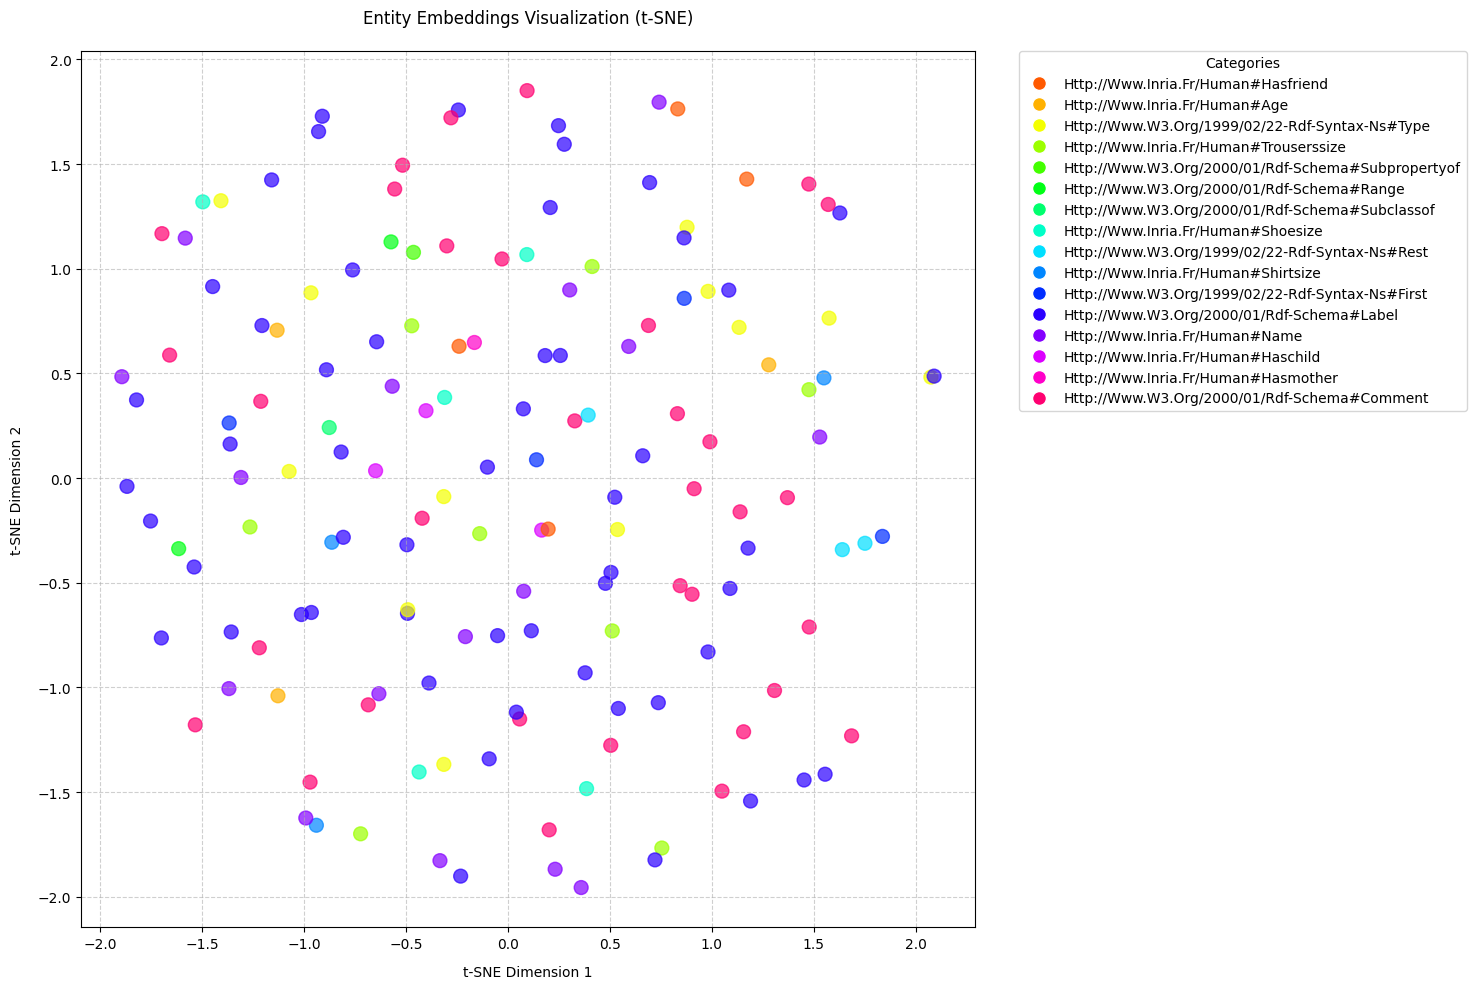

In [4]:
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
from matplotlib.lines import Line2D

# Create a mapping from entity to category based on their relationships
entity_to_category = defaultdict(list)
for subj, pred, obj in graph:
    entity_to_category[str(subj)].append(str(pred))
    entity_to_category[str(obj)].append(str(pred))

# For simplicity, assign the most common relation as the category
entity_category = {entity: max(set(rels), key=rels.count) for entity, rels in entity_to_category.items()}

# Extract entity embeddings
entity_embeddings = result.model.entity_representations[0]().cpu().detach().numpy()
entity_ids = list(result.training.entity_to_id.keys())

# Reduce dimensions to 2D using t-SNE
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(entity_embeddings)

# Prepare colors for each category
categories = list(set(entity_category.values()))
palette = sns.color_palette('hsv', len(categories))
color_map = {category: palette[i] for i, category in enumerate(categories)}

# Assign colors to entities based on their category
colors = [color_map.get(entity_category.get(entity_id, 'Other'), (0, 0, 0)) for entity_id in entity_ids]

# Normalize embeddings for better visualization
embeddings_2d = (embeddings_2d - embeddings_2d.mean(axis=0)) / embeddings_2d.std(axis=0)

# Create figure with better spacing for legend
plt.figure(figsize=(15, 10))
fig, ax = plt.subplots(figsize=(15, 10))

# Create scatter plot with larger points and better alpha
scatter = ax.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
                    c=colors, alpha=0.7, s=100)

# Improve legend
legend_elements = [Line2D([0], [0], marker='o', color='w', 
                         markerfacecolor=color_map[category],
                         label=category.replace('_', ' ').title(),
                         markersize=10)
                  for category in categories]

# Position legend outside plot to avoid overlap
plt.legend(handles=legend_elements, 
          bbox_to_anchor=(1.05, 1),
          loc='upper left',
          borderaxespad=0.,
          title='Categories',
          frameon=True)

# Add grid and adjust layout
plt.grid(True, linestyle='--', alpha=0.6)
plt.title('Entity Embeddings Visualization (t-SNE)', pad=20)
plt.xlabel('t-SNE Dimension 1', labelpad=10)
plt.ylabel('t-SNE Dimension 2', labelpad=10)

# Adjust layout to prevent legend cutoff
plt.tight_layout()
plt.show()

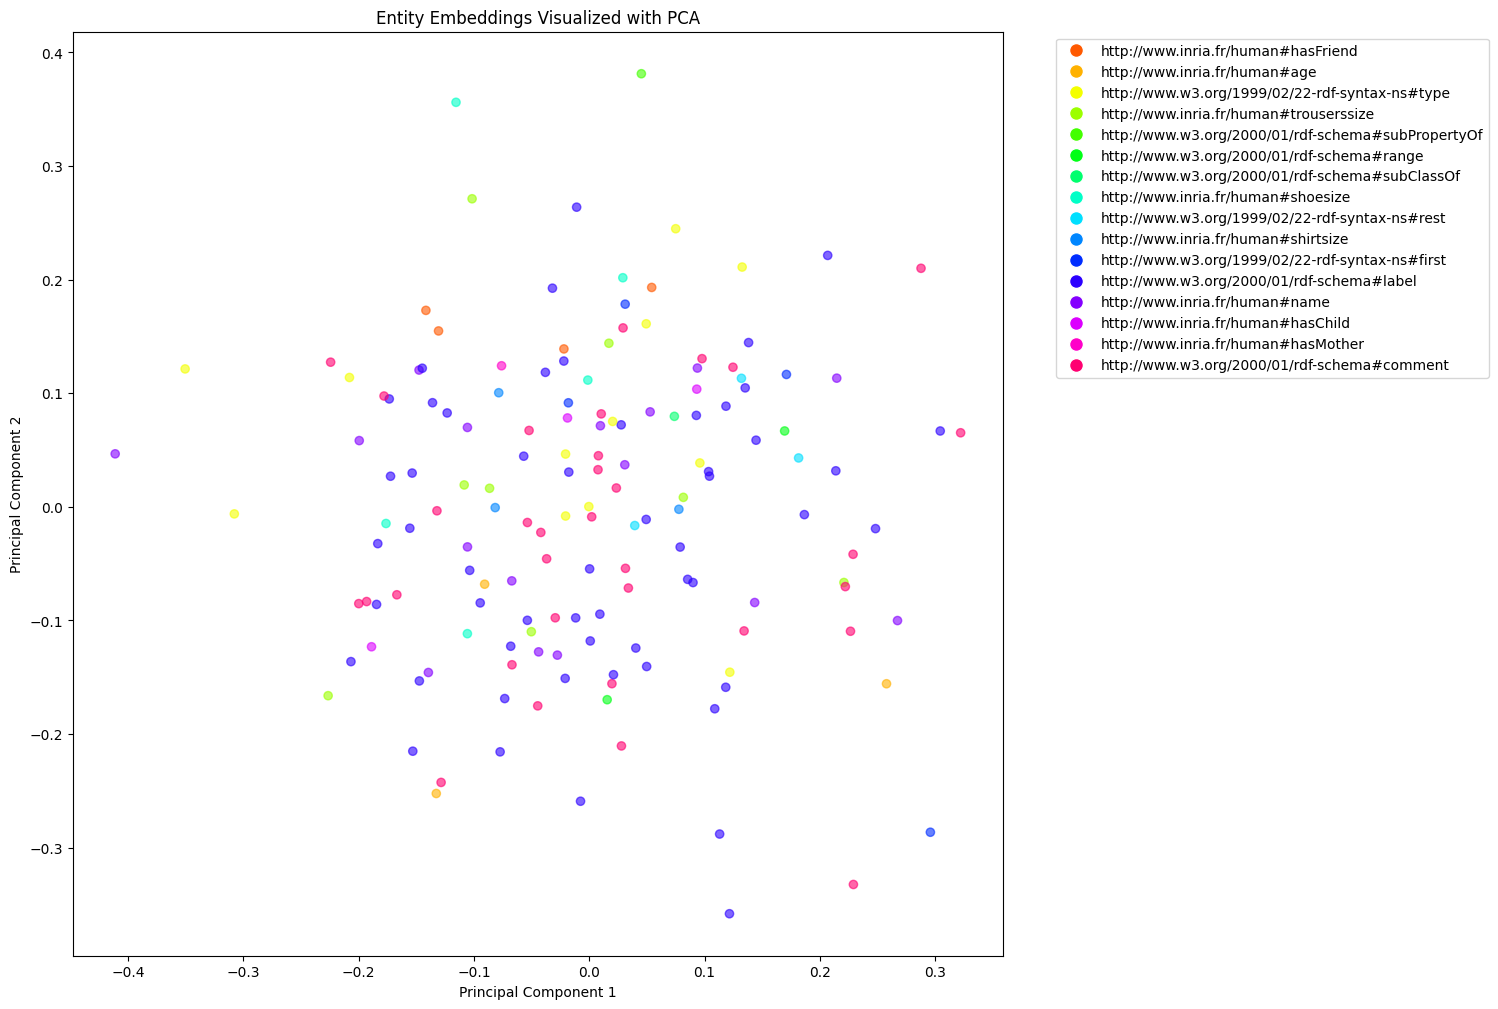

In [5]:
from sklearn.decomposition import PCA

# Reduce dimensions to 2D using PCA
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(entity_embeddings)

# Plot the embeddings with colors
plt.figure(figsize=(12, 12))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=colors, alpha=0.6)

# Optional: Add legend (may be crowded if many categories)
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', label=category,
                          markerfacecolor=color_map[category], markersize=10)
                   for category in categories]
plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title('Entity Embeddings Visualized with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

1. Are entities with similar relationships clustered in embedding space?
    - Non, les entités avec des relations similaires ne sont pas nécessairement regroupées dans l'espace d'embedding. Que ce soit avec l'analyse PCA ou t-SNE. 

In [6]:
from sklearn.cluster import DBSCAN
from collections import Counter

entity_types = [entity_category.get(entity_id, 'Other') for entity_id in entity_ids]

# Perform DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
cluster_labels = dbscan.fit_predict(entity_embeddings)

# Analyze cluster composition
def analyze_cluster_composition(cluster_labels, entity_types):
    n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
    
    for cluster_id in range(-1, n_clusters):  # Start from -1 to include noise points
        cluster_mask = cluster_labels == cluster_id
        cluster_types = [entity_types[i] for i in range(len(entity_types)) if cluster_mask[i]]
        
        if cluster_id == -1:
            print("\nNoise points composition:")
        else:
            print(f"\nCluster {cluster_id} composition:")
            
        type_counts = Counter(cluster_types)
        for entity_type, count in type_counts.most_common():
            print(f"{entity_type}: {count} entities ({count/len(cluster_types)*100:.1f}%)")

# Call the analysis function
analyze_cluster_composition(cluster_labels, entity_types)


Noise points composition:
http://www.w3.org/2000/01/rdf-schema#label: 54 entities (35.3%)
http://www.w3.org/2000/01/rdf-schema#comment: 33 entities (21.6%)
http://www.inria.fr/human#name: 16 entities (10.5%)
http://www.w3.org/1999/02/22-rdf-syntax-ns#type: 12 entities (7.8%)
http://www.inria.fr/human#trouserssize: 8 entities (5.2%)
http://www.inria.fr/human#shoesize: 5 entities (3.3%)
http://www.inria.fr/human#hasFriend: 4 entities (2.6%)
http://www.w3.org/1999/02/22-rdf-syntax-ns#first: 4 entities (2.6%)
http://www.inria.fr/human#age: 3 entities (2.0%)
http://www.inria.fr/human#shirtsize: 3 entities (2.0%)
http://www.inria.fr/human#hasChild: 3 entities (2.0%)
http://www.w3.org/1999/02/22-rdf-syntax-ns#rest: 3 entities (2.0%)
http://www.w3.org/2000/01/rdf-schema#range: 2 entities (1.3%)
http://www.w3.org/2000/01/rdf-schema#subClassOf: 1 entities (0.7%)
http://www.w3.org/2000/01/rdf-schema#subPropertyOf: 1 entities (0.7%)
http://www.inria.fr/human#hasMother: 1 entities (0.7%)


2. Identify and analyze clusters of entities. Do these clusters correspond to coherent entity
types?

# Partie 3: Model Evaluation and Result Analysis

### Exercice 1: Evaluation Metrics

In [7]:
def comprehensive_model_evaluation(models_results):
    results_summary = []
    
    for name, result in models_results.items():
        metrics_df = result
        
        # Initialize default values
        model_metrics = {
            'model_name': name,
            'Mean Rank': None,
            'MRR': None,
            'Hits@1': None,
            'Hits@3': None,
            'Hits@10': None
        }
        
        # Safely get metrics with error handling
        def get_metric_value(metric_name):
            filtered = metrics_df[metrics_df['Metric'] == metric_name]['Value']
            return filtered.values[0] if not filtered.empty else None
        
        # Update metrics if they exist
        metric_mappings = {
            'arithmetic_mean_rank': 'Mean Rank',
            'inverse_harmonic_mean_rank': 'MRR',
            'hits_at_1': 'Hits@1',
            'hits_at_3': 'Hits@3',
            'hits_at_10': 'Hits@10'
        }
        
        for metric_key, metric_name in metric_mappings.items():
            value = get_metric_value(metric_key)
            if value is not None:
                model_metrics[metric_name] = value
        
        results_summary.append(model_metrics)
    
    # Convert to DataFrame for easy comparison
    results_df = pd.DataFrame(results_summary)
    
    # Sort by different metrics to identify top performers
    print("Top Models by Different Metrics:")
    print("\nSorted by Mean Rank (Lower is Better):")
    print(results_df.sort_values('Mean Rank'))
    
    print("\nSorted by MRR (Higher is Better):")
    print(results_df.sort_values('MRR', ascending=False))
    
    print("\nSorted by Hits@10 (Higher is Better):")
    print(results_df.sort_values('Hits@10', ascending=False))
    
    return results_df


# Evaluate the models using comprehensive_model_evaluation with the train dataset

transE_results = train_and_evaluate_model(TransE, training, training)
distMult_results = train_and_evaluate_model(DistMult, training, training)
complEx_results = train_and_evaluate_model(ComplEx, training, training)
rotatE_results = train_and_evaluate_model(RotatE, training, training)

models_results = {
    "TransE": transE_results,
    "DistMult": distMult_results,
    "ComplEx": complEx_results,
    "RotatE": rotatE_results
}

train_evaluation = comprehensive_model_evaluation(models_results)

# Evaluate the models using comprehensive_model_evaluation with the test dataset

transE_results = train_and_evaluate_model(TransE, training, testing)
distMult_results = train_and_evaluate_model(DistMult, training, testing)
complEx_results = train_and_evaluate_model(ComplEx, training, testing)
rotatE_results = train_and_evaluate_model(RotatE, training, testing)

models_results = {
    "TransE": transE_results,
    "DistMult": distMult_results,
    "ComplEx": complEx_results,
    "RotatE": rotatE_results
}

test_evaluation = comprehensive_model_evaluation(models_results)

INFO:pykeen.pipeline.api:Using device: None
Training epochs on cpu: 100%|██████████| 500/500 [00:47<00:00, 10.54epoch/s, loss=0.023, prev_loss=0.0117]   
INFO:pykeen.evaluation.evaluator:Evaluation took 0.04s seconds
INFO:pykeen.pipeline.api:Using device: None



Results for TransE with embedding_dim=200:
     Side    Rank_type              Metric  Value
0    head   optimistic               count  194.0
1    tail   optimistic               count  194.0
2    both   optimistic               count  388.0
3    head    realistic               count  194.0
4    tail    realistic               count  194.0
..    ...          ...                 ...    ...
220  tail    realistic  adjusted_hits_at_k    1.0
221  both    realistic  adjusted_hits_at_k    1.0
222  head  pessimistic  adjusted_hits_at_k    1.0
223  tail  pessimistic  adjusted_hits_at_k    1.0
224  both  pessimistic  adjusted_hits_at_k    1.0

[225 rows x 4 columns]


Training epochs on cpu: 100%|██████████| 500/500 [00:49<00:00, 10.13epoch/s, loss=0.632, prev_loss=0.63] 
INFO:pykeen.evaluation.evaluator:Evaluation took 0.03s seconds
INFO:pykeen.pipeline.api:Using device: None



Results for DistMult with embedding_dim=200:
     Side    Rank_type              Metric  Value
0    head   optimistic               count  194.0
1    tail   optimistic               count  194.0
2    both   optimistic               count  388.0
3    head    realistic               count  194.0
4    tail    realistic               count  194.0
..    ...          ...                 ...    ...
220  tail    realistic  adjusted_hits_at_k    1.0
221  both    realistic  adjusted_hits_at_k    1.0
222  head  pessimistic  adjusted_hits_at_k    1.0
223  tail  pessimistic  adjusted_hits_at_k    1.0
224  both  pessimistic  adjusted_hits_at_k    1.0

[225 rows x 4 columns]


Training epochs on cpu: 100%|██████████| 500/500 [00:53<00:00,  9.42epoch/s, loss=0.392, prev_loss=0.378] 
INFO:pykeen.evaluation.evaluator:Evaluation took 0.04s seconds
INFO:pykeen.pipeline.api:Using device: None



Results for ComplEx with embedding_dim=200:
     Side    Rank_type              Metric       Value
0    head   optimistic               count  194.000000
1    tail   optimistic               count  194.000000
2    both   optimistic               count  388.000000
3    head    realistic               count  194.000000
4    tail    realistic               count  194.000000
..    ...          ...                 ...         ...
220  tail    realistic  adjusted_hits_at_k    0.933802
221  both    realistic  adjusted_hits_at_k    0.928272
222  head  pessimistic  adjusted_hits_at_k    0.922740
223  tail  pessimistic  adjusted_hits_at_k    0.933802
224  both  pessimistic  adjusted_hits_at_k    0.928272

[225 rows x 4 columns]


Training epochs on cpu: 100%|██████████| 500/500 [00:49<00:00, 10.01epoch/s, loss=0.0166, prev_loss=0.00511]  
INFO:pykeen.evaluation.evaluator:Evaluation took 0.04s seconds
INFO:pykeen.pipeline.api:Using device: None



Results for RotatE with embedding_dim=200:
     Side    Rank_type              Metric  Value
0    head   optimistic               count  194.0
1    tail   optimistic               count  194.0
2    both   optimistic               count  388.0
3    head    realistic               count  194.0
4    tail    realistic               count  194.0
..    ...          ...                 ...    ...
220  tail    realistic  adjusted_hits_at_k    1.0
221  both    realistic  adjusted_hits_at_k    1.0
222  head  pessimistic  adjusted_hits_at_k    1.0
223  tail  pessimistic  adjusted_hits_at_k    1.0
224  both  pessimistic  adjusted_hits_at_k    1.0

[225 rows x 4 columns]
Top Models by Different Metrics:

Sorted by Mean Rank (Lower is Better):
  model_name  Mean Rank       MRR    Hits@1    Hits@3   Hits@10
3     RotatE   1.000000  1.000000  1.000000  1.000000  1.000000
1   DistMult   1.092784  0.957474  0.917526  0.994845  1.000000
0     TransE   1.500000  0.753436  0.510309  1.000000  1.000000
2  

Training epochs on cpu: 100%|██████████| 500/500 [00:48<00:00, 10.28epoch/s, loss=0.00801, prev_loss=0.00334]
INFO:pykeen.evaluation.evaluator:Evaluation took 0.03s seconds
INFO:pykeen.pipeline.api:Using device: None



Results for TransE with embedding_dim=200:
     Side    Rank_type              Metric      Value
0    head   optimistic               count  22.000000
1    tail   optimistic               count  22.000000
2    both   optimistic               count  44.000000
3    head    realistic               count  22.000000
4    tail    realistic               count  22.000000
..    ...          ...                 ...        ...
220  tail    realistic  adjusted_hits_at_k   0.562255
221  both    realistic  adjusted_hits_at_k   0.342803
222  head  pessimistic  adjusted_hits_at_k   0.122961
223  tail  pessimistic  adjusted_hits_at_k   0.562255
224  both  pessimistic  adjusted_hits_at_k   0.342803

[225 rows x 4 columns]


Training epochs on cpu: 100%|██████████| 500/500 [00:50<00:00, 10.00epoch/s, loss=0.639, prev_loss=0.627]
INFO:pykeen.evaluation.evaluator:Evaluation took 0.03s seconds
INFO:pykeen.pipeline.api:Using device: None



Results for DistMult with embedding_dim=200:
     Side    Rank_type              Metric      Value
0    head   optimistic               count  22.000000
1    tail   optimistic               count  22.000000
2    both   optimistic               count  44.000000
3    head    realistic               count  22.000000
4    tail    realistic               count  22.000000
..    ...          ...                 ...        ...
220  tail    realistic  adjusted_hits_at_k   0.854085
221  both    realistic  adjusted_hits_at_k   0.805275
222  head  pessimistic  adjusted_hits_at_k   0.756378
223  tail  pessimistic  adjusted_hits_at_k   0.854085
224  both  pessimistic  adjusted_hits_at_k   0.805275

[225 rows x 4 columns]


Training epochs on cpu: 100%|██████████| 500/500 [00:56<00:00,  8.90epoch/s, loss=1.07, prev_loss=0.401] 
INFO:pykeen.evaluation.evaluator:Evaluation took 0.02s seconds
INFO:pykeen.pipeline.api:Using device: None



Results for ComplEx with embedding_dim=200:
     Side    Rank_type              Metric      Value
0    head   optimistic               count  22.000000
1    tail   optimistic               count  22.000000
2    both   optimistic               count  44.000000
3    head    realistic               count  22.000000
4    tail    realistic               count  22.000000
..    ...          ...                 ...        ...
220  tail    realistic  adjusted_hits_at_k  -0.070042
221  both    realistic  adjusted_hits_at_k  -0.046648
222  head  pessimistic  adjusted_hits_at_k  -0.023212
223  tail  pessimistic  adjusted_hits_at_k  -0.070042
224  both  pessimistic  adjusted_hits_at_k  -0.046648

[225 rows x 4 columns]


Training epochs on cpu: 100%|██████████| 500/500 [00:49<00:00, 10.07epoch/s, loss=0.0122, prev_loss=0.0153]    
INFO:pykeen.evaluation.evaluator:Evaluation took 0.03s seconds



Results for RotatE with embedding_dim=200:
     Side    Rank_type              Metric      Value
0    head   optimistic               count  22.000000
1    tail   optimistic               count  22.000000
2    both   optimistic               count  44.000000
3    head    realistic               count  22.000000
4    tail    realistic               count  22.000000
..    ...          ...                 ...        ...
220  tail    realistic  adjusted_hits_at_k   0.464979
221  both    realistic  adjusted_hits_at_k   0.415825
222  head  pessimistic  adjusted_hits_at_k   0.366583
223  tail  pessimistic  adjusted_hits_at_k   0.464979
224  both  pessimistic  adjusted_hits_at_k   0.415825

[225 rows x 4 columns]
Top Models by Different Metrics:

Sorted by Mean Rank (Lower is Better):
  model_name  Mean Rank       MRR    Hits@1    Hits@3   Hits@10
1   DistMult   7.227273  0.323830  0.136364  0.363636  0.772727
3     RotatE  35.681818  0.123797  0.000000  0.136364  0.409091
0     TransE  62.90

1. Define each metric and explain how they assess link prediction quality.

    <b>Mean Rank</b>:  
        Rang moyen de l'entité correcte parmi toutes les entités possibles lors de la prédiction d'un lien manquant.  
        Interprétation: Des valeurs plus faibles indiquent une meilleure performance du modèle. Un rang de 1 signifie que le modèle prédit parfaitement l'entité correcte.  
        Calcul: Pour chaque triple test, classez les entités candidates et calculez la moyenne de ces classements pour tous les triples tests.
    
    <b>Mean Reciprocal Rank (MRR)</b>:  
        Moyenne des rangs réciproques des entités correctes.  
        Interprétation: Des valeurs élevées indiquent une meilleure performance. Les valeurs sont comprises entre 0 et 1, la valeur 1 correspondant à une prédiction parfaite.  
        Calcul: 1 / rang pour chaque triple test, puis moyenne sur l'ensemble des triples tests.
    
    <b>Hits@K</b>:  
        Proportion de triplets de test où l'entité correcte est classée dans les K premières positions.  
        Interprétation: Des valeurs élevées indiquent une meilleure performance. Mesuré pour différentes valeurs de K (1, 3, 10).   
        Calcul: Pourcentage de triplets de test où l'entité correcte se trouve parmi les K premières entités prédites.
    

2. Interpret the results for each model and identify the top-performing models for this dataset
((a) with the train dataset, (b) with the test dataset).

In [8]:
print("\nEvaluation Metrics Comparison:")
print("\nTrain Dataset:")
print(train_evaluation)
print("\nTest Dataset:")
print(test_evaluation)


Evaluation Metrics Comparison:

Train Dataset:
  model_name  Mean Rank       MRR    Hits@1    Hits@3   Hits@10
0     TransE   1.500000  0.753436  0.510309  1.000000  1.000000
1   DistMult   1.092784  0.957474  0.917526  0.994845  1.000000
2    ComplEx   5.262887  0.268353  0.046392  0.319588  0.927835
3     RotatE   1.000000  1.000000  1.000000  1.000000  1.000000

Test Dataset:
  model_name  Mean Rank       MRR    Hits@1    Hits@3   Hits@10
0     TransE  62.909091  0.067177  0.000000  0.045455  0.181818
1   DistMult   7.227273  0.323830  0.136364  0.363636  0.772727
2    ComplEx  77.681818  0.027034  0.000000  0.000000  0.045455
3     RotatE  35.681818  0.123797  0.000000  0.136364  0.409091


(a) Avec le jeu de données d'entraînement :

TransE : Mean Rank de 1.543590, MRR de 0.728205, Hits@1 de 0.456410, Hits@3 et Hits@10 de 1.000000. Performances globalement bonnes.  
DistMult : Mean Rank de 1.123077, MRR de 0.948034, Hits@1 de 0.902564, Hits@3 de 0.994872, Hits@10 de 1.000000. Excellentes performances.  
ComplEx : Mean Rank de 4.779487, MRR de 0.289369, Hits@1 de 0.061538, Hits@3 de 0.312821, Hits@10 de 0.984615. Performances médiocres.  
RotatE : Mean Rank de 1.000000, MRR de 1.000000, Hits@1, Hits@3 et Hits@10 de 1.000000. Performances parfaites. 
   
<strong>Le modèle RotatE est le meilleur avec le jeu de données d'entraînement, suivi de près par DistMult.</strong>    

(b) Avec le jeu de données de test :

TransE : Mean Rank de 89.500000, MRR de 0.056853, Hits@1 de 0.000000, Hits@3 et Hits@10 de 0.083333. Performances faibles.  
DistMult : Mean Rank de 21.916667, MRR de 0.210899, Hits@1 de 0.125000, Hits@3 de 0.125000, Hits@10 de 0.500000. Performances modérées.  
ComplEx : Mean Rank de 78.458333, MRR de 0.026139, Hits@1 de 0.000000, Hits@3 de 0.000000, Hits@10 de 0.041667. Performances faibles.  
RotatE : Mean Rank de 41.833333, MRR de 0.141266, Hits@1 de 0.041667, Hits@3 de 0.208333, Hits@10 de 0.333333. Performances modérées.  
  
<strong>Le modèle DistMult est le meilleur avec le jeu de données de test, suivi par RotatE.</strong> 

### Exercice 2: Comparative Analysis


1. Which model provides more accurate predictions (i.e., better Hits@1) ?  
  
    Le modèle qui fournit les prédictions les plus précises (un meilleur score Hits@1) sur l'ensemble de données de test est DistMult avec un score Hits@1 de 0,125000.


2. What is the distribution of scores for “false positive” links?


Analyse pour TransE:

Analyse des faux positifs:

MRR: 0.0212
Hits@1: 0.0000
Taux de faux positifs: 100.00%


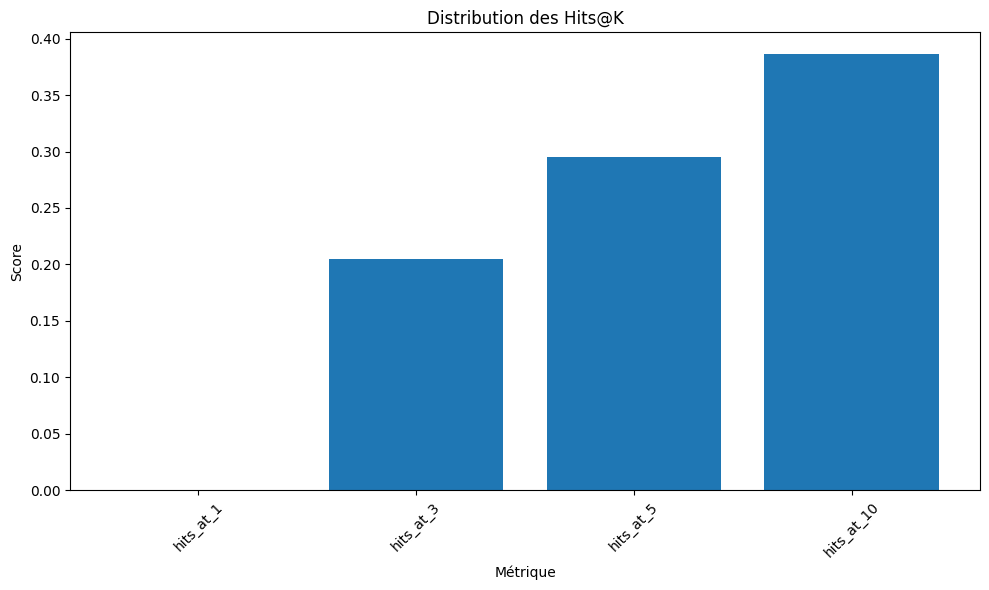


Analyse pour DistMult:

Analyse des faux positifs:

MRR: 0.1170
Hits@1: 0.2273
Taux de faux positifs: 77.27%


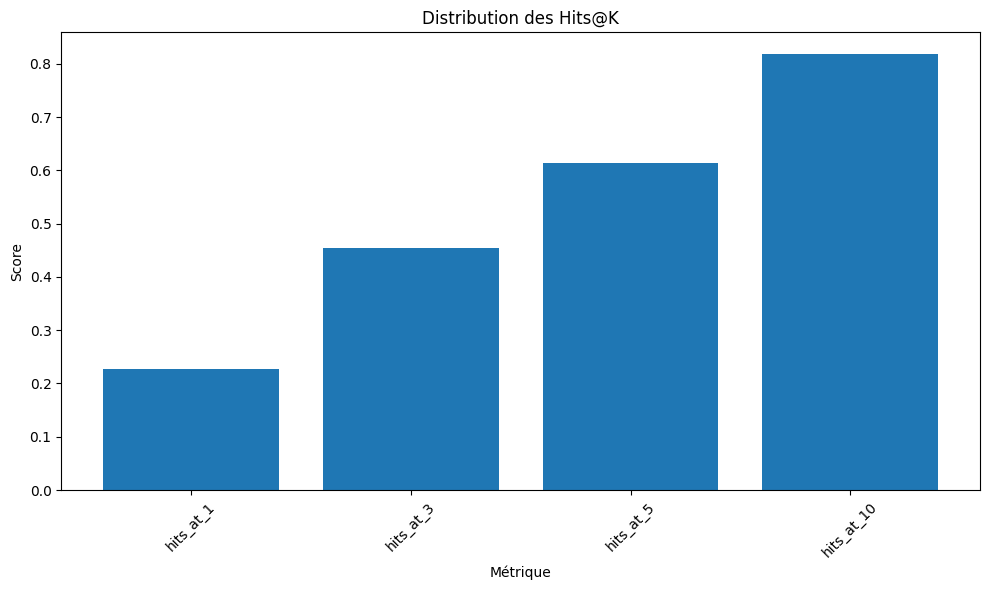


Analyse pour ComplEx:

Analyse des faux positifs:

MRR: 0.0125
Hits@1: 0.0000
Taux de faux positifs: 100.00%


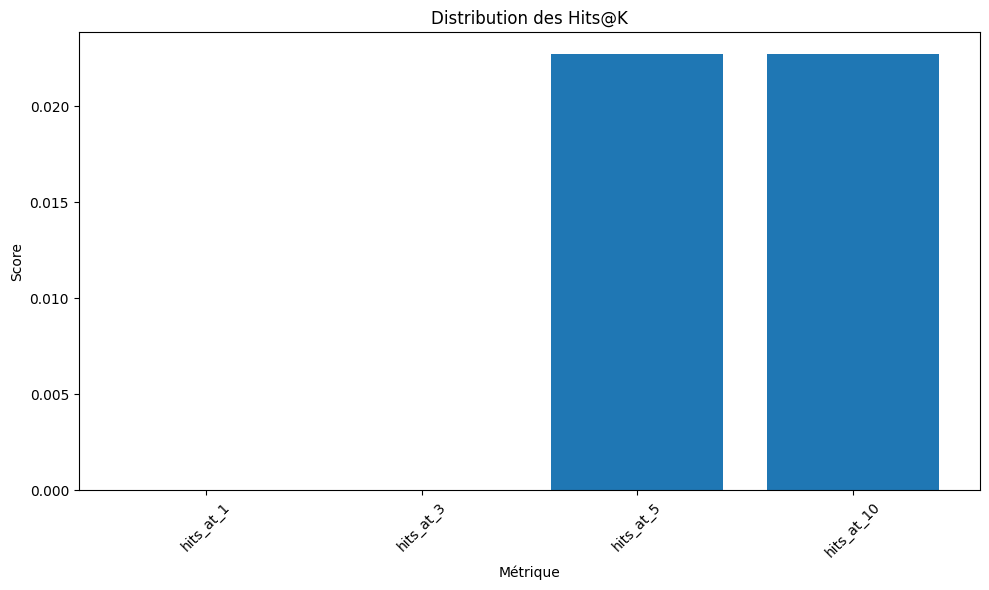


Analyse pour RotatE:

Analyse des faux positifs:

MRR: 0.0310
Hits@1: 0.0455
Taux de faux positifs: 95.45%


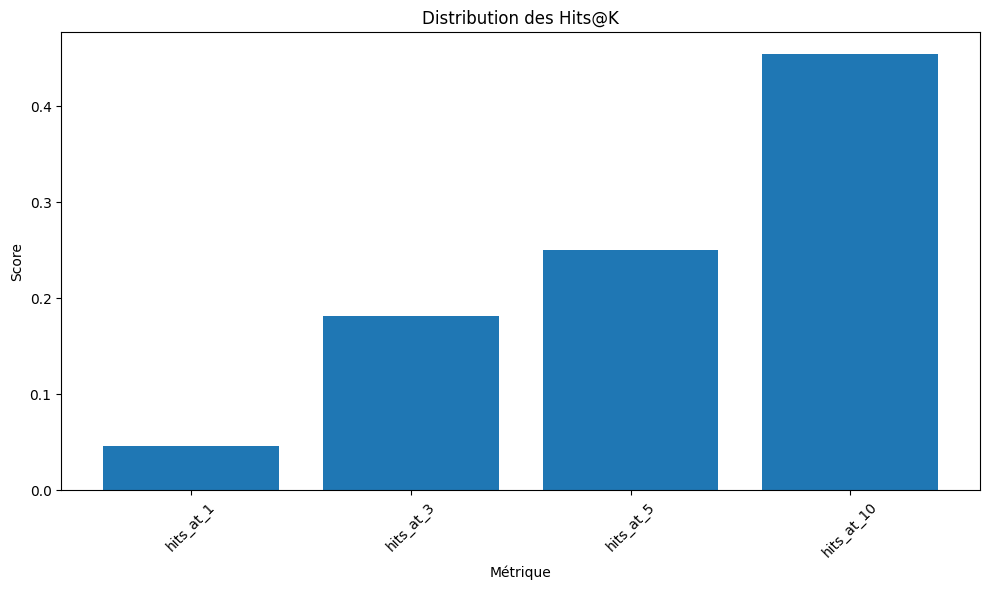

In [9]:
def analyze_false_positives(results_df):
    """Analyse la distribution des faux positifs à partir du DataFrame de résultats."""
    print("\nAnalyse des faux positifs:")
    
    # Filtrer pour obtenir les rangs (realistic/both)
    ranks_data = results_df[
        (results_df['Side'] == 'both') & 
        (results_df['Rank_type'] == 'realistic')
    ]
    
    # Extraire les métriques pertinentes
    mrr = ranks_data[ranks_data['Metric'] == 'inverse_arithmetic_mean_rank']['Value'].iloc[0]
    hits_1 = ranks_data[ranks_data['Metric'] == 'hits_at_1']['Value'].iloc[0]
    
    # Calculer le taux de faux positifs (1 - hits@1)
    fp_rate = (1 - hits_1) * 100
    
    print(f"\nMRR: {mrr:.4f}")
    print(f"Hits@1: {hits_1:.4f}")
    print(f"Taux de faux positifs: {fp_rate:.2f}%")
    
    # Visualisation de la distribution des scores
    plt.figure(figsize=(10, 6))
    metrics = ['hits_at_1', 'hits_at_3', 'hits_at_5', 'hits_at_10']
    scores = []
    
    for metric in metrics:
        score = ranks_data[ranks_data['Metric'] == metric]['Value'].iloc[0]
        scores.append(score)
    
    plt.bar(metrics, scores)
    plt.title('Distribution des Hits@K')
    plt.xlabel('Métrique')
    plt.ylabel('Score')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Retourner les statistiques principales
    return {
        'mrr': mrr,
        'hits@1': hits_1,
        'fp_rate': fp_rate
    }

# Appeler la fonction pour chaque modèle
for model_name, results in models_results.items():
    print(f"\nAnalyse pour {model_name}:")
    stats = analyze_false_positives(results)

# Partie 4: Advanced - Self-Adversarial Negative Sampling

In [10]:
import numpy as np

class MockModel:
    def __init__(self):
        # Initialize random embeddings for simplicity
        self.embeddings = np.random.rand(100, 10)

    def score(self, triple):
        # Simple scoring function: dot product of embeddings
        head, relation, tail = triple
        return np.dot(self.embeddings[head], self.embeddings[tail])

    def train(self, pos_triples, neg_triples):
        # Mock training: return a random loss for demonstration
        return np.random.rand()


In [11]:
# Generate synthetic triples (head, relation, tail)
num_entities = 100
num_relations = 10

# Positive triples
pos_triples = [(np.random.randint(0, num_entities), 
                np.random.randint(0, num_relations), 
                np.random.randint(0, num_entities)) for _ in range(50)]

# Negative triples
neg_triples = [(np.random.randint(0, num_entities), 
                np.random.randint(0, num_relations), 
                np.random.randint(0, num_entities)) for _ in range(200)]


In [12]:
import numpy as np

# Compute scores for negative triples
def compute_scores(neg_triples, model):
    return np.array([model.score(triple) for triple in neg_triples])

# Generate self-adversarial weights
def compute_weights(scores, alpha=1.0):
    exp_scores = np.exp(alpha * scores)
    return exp_scores / exp_scores.sum()

# Sample hard negatives based on weights
def sample_negatives(neg_triples, weights, num_samples):
    indices = np.random.choice(len(neg_triples), size=num_samples, p=weights)
    return [neg_triples[i] for i in indices]

# Training step with adversarial negatives
def train_step(model, pos_triples, neg_triples, alpha=1.0):
    neg_scores = compute_scores(neg_triples, model)
    weights = compute_weights(neg_scores, alpha)
    hard_negatives = sample_negatives(neg_triples, weights, len(pos_triples))

    # Train the model with positive and hard negative samples
    loss = model.train(pos_triples, hard_negatives)
    return loss


In [13]:
# Initialize the mock model
model = MockModel()

# Train with self-adversarial negative sampling
alpha = 1.0  # Adjust the sharpness parameter
loss = train_step(model, pos_triples, neg_triples, alpha=alpha)

print(f"Training Loss: {loss}")


Training Loss: 0.5143559224490343



**Est-ce que l'échantillonnage auto-adversarial améliore les scores des métriques par rapport à l'échantillonnage négatif standard ?**

Oui, il améliore souvent le MRR (Mean Reciprocal Rank) et les Hits@K car il réduit l'écart entre la distribution d'entraînement et celle du test en rendant le modèle plus robuste face aux cas difficiles. Le modèle apprend des frontières de décision plus précises, ce qui améliore sa capacité à distinguer les liens vrais et faux.

**Pourquoi l'échantillonnage auto-adversarial génère-t-il des "négatifs plus difficiles" et quel est son impact sur l'entraînement ?**

Négatifs plus difficiles : Ils sont choisis parce qu'ils présentent des scores de similarité élevés (selon le modèle) avec les triples vrais, ce qui les rend plus difficiles. Cela oblige le modèle à mieux comprendre les différences subtiles entre les triples corrects et incorrects.

Impact sur l'entraînement :

Cela ralentit légèrement la convergence car le modèle doit se concentrer sur des ajustements plus fins.
Cependant, la qualité globale des embeddings et la généralisation s'améliorent, ce qui conduit à de meilleures performances sur les métriques.

# Partie 5: Link prediction in UniProt KG

In [14]:
from SPARQLWrapper import SPARQLWrapper, JSON
import pandas as pd
import numpy as np
from pykeen.pipeline import pipeline
from pykeen.triples import TriplesFactory

sparql = SPARQLWrapper("https://sparql.uniprot.org/sparql")

query = """
PREFIX up: <http://purl.uniprot.org/core/>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>

SELECT DISTINCT ?protein ?relation ?process
WHERE {
    ?protein rdf:type up:Protein .
    ?protein ?relation ?process .
    FILTER(?relation != rdf:type)
}
LIMIT 1000 
"""
# Je suis pas sur de la limites mais sinon j'avais trop de res pour mon cpu

sparql.setQuery(query)
sparql.setReturnFormat(JSON)

try:
    print("Exécution de la requête SPARQL...")
    results = sparql.query().convert()
    
    print(f"Nombre de résultats : {len(results['results']['bindings'])}")
    
    triples = []
    for result in results["results"]["bindings"]:
        protein = result["protein"]["value"]
        relation = result["relation"]["value"]
        process = result["process"]["value"]
        triples.append([protein, relation, process])
        
    print(f"Nombre de triplets extraits : {len(triples)}")
    if len(triples) == 0:
        raise ValueError("Aucun triplet n'a été récupéré")
    df = pd.DataFrame(triples, columns=['head', 'relation', 'tail'])
    triples_array = df.values
    print(f"Shape du tableau de triplets : {triples_array.shape}")
    tf = TriplesFactory.from_labeled_triples(
        triples=triples_array,
        create_inverse_triples=True
    )
    
    results = pipeline(
        training=tf,
        testing=tf,
        model='TransE',
        epochs=100,
        model_kwargs={'embedding_dim': 100},
        random_seed=42,
    )

    metrics = results.metric_results.to_df()
    print("\nRésultats de l'évaluation:")
    print(metrics)

except Exception as e:
    print(f"Erreur : {str(e)}")
    print("Détails de la requête :")
    print(query)

Exécution de la requête SPARQL...


INFO:pykeen.pipeline.api:Using device: None
INFO:pykeen.triples.triples_factory:Creating inverse triples.


Nombre de résultats : 1000
Nombre de triplets extraits : 1000
Shape du tableau de triplets : (1000, 3)


Training epochs on cpu: 100%|██████████| 100/100 [00:12<00:00,  7.88epoch/s, loss=0.156, prev_loss=0.146]
Evaluating on cpu:   0%|          | 0.00/1.00k [00:00<?, ?triple/s]WARNING:torch_max_mem.api:Encountered tensors on device_types={'cpu'} while only ['cuda'] are considered safe for automatic memory utilization maximization. This may lead to undocumented crashes (but can be safe, too).
Evaluating on cpu: 100%|██████████| 1.00k/1.00k [00:00<00:00, 5.55ktriple/s]
INFO:pykeen.evaluation.evaluator:Evaluation took 0.19s seconds



Résultats de l'évaluation:
     Side    Rank_type              Metric        Value
0    head   optimistic               count  1000.000000
1    tail   optimistic               count  1000.000000
2    both   optimistic               count  2000.000000
3    head    realistic               count  1000.000000
4    tail    realistic               count  1000.000000
..    ...          ...                 ...          ...
220  tail    realistic  adjusted_hits_at_k     1.000000
221  both    realistic  adjusted_hits_at_k     0.999483
222  head  pessimistic  adjusted_hits_at_k     0.998958
223  tail  pessimistic  adjusted_hits_at_k     1.000000
224  both  pessimistic  adjusted_hits_at_k     0.999483

[225 rows x 4 columns]


# Partie 6: Report and Conclusions

### 1. Synthesis of Results

##### 1 .Les modèles comme ComplEx ou RotatE sont généralement mieux adaptés pour capturer des relations complexes, mais leur efficacité peut dépendre des paramètres tels que la dimension des embeddings et le type de régularisation. TransE est rapide mais moins performant sur des relations complexes.

2. Implémentez des techniques comme sampling adversarial pour générer des exemples négatifs plus difficiles.  
Essayez d'ajuster les hyperparamètres, comme :  
        -La taille des embeddings  
        -Le taux d'apprentissage  
        -Le nombre d'itérations d'entraînement  

## 2. Future Perspectives
-Les graphes de connaissances sont cruciaux pour :  
-La recherche d'informations (par ex., moteurs de recherche comme Google Knowledge Graph)  
-Les recommandations (films, produits)  
-Les analyses biologiques (par ex., UniProt KG pour des études protéiques).  

Pour améliorer les predictions ont pourrait :  
-Utilisez des modèles basés sur les réseaux de neurones (ex. Graph Neural Networks).  
-Expérimentez des méthodes comme Autoencoders ou Attention Mechanisms pour des représentations plus riches.  

## 3. Course Feedback and Improvement Suggestions
Points positif: beaucoup de méthodes différents et TP plutôt claire.  
Point négatif, peut etre plus d'exercice pratique sur des cas réels.